<a href="https://colab.research.google.com/github/Totti00/VA_Project/blob/main/VA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First commit

In [ ]:
!wget https://www.dropbox.com/scl/fi/ybx2y1kvy99e2240gc9gg/san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn&dl=0
!unzip -q san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn
!rm san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install uvicorn
!pip install python-multipart
!pip install kaleido
!pip install fastapi
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [17]:
import os
from PIL import Image
import math
import json
import torch
from timeit import default_timer as timer
from datetime import timedelta
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import directed_hausdorff
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#import supervision as sv
from sklearn.decomposition import PCA

def resize_img(img_path, input_size):
  my_image = plt.imread(img_path)
  print(my_image.shape)
  if max(my_image.shape[0], my_image.shape[1]) > input_size:
    if my_image.shape[0] >= my_image.shape[1]:
      height = input_size
      width = int(my_image.shape[1] * input_size / my_image.shape[0])
    else:
      width = input_size
      height = int(my_image.shape[0] * input_size / my_image.shape[1])
    my_image = cv2.resize(my_image, (width, height), interpolation=cv2.INTER_LINEAR)
  plt.imsave(img_path, my_image)

def pad_img(img_path, input_size):
  my_image = plt.imread(img_path)
  pad_width = input_size - my_image.shape[0]
  pad_height = input_size - my_image.shape[1]
  my_padded_image = np.pad(my_image, ((0, pad_width), (0, pad_height), (0, 0)), 'constant')
  plt.imsave(img_path, my_padded_image)

def crop_image(image):
  cropped_image = image[1000:, 1500:]
  cropped_image = cropped_image[:2400, :2600]
  return cropped_image

def sliding_window_hausdorff_distance(contoursA, contoursB, window_size):
  min_distance = float('inf')

  # Confronta l'array più piccolo con una porzione dell'array più grande
  for i in range(len(contoursB) - window_size + 1):
    window_contoursB = contoursB[i:i+window_size]

    # Calcola la distanza di Hausdorff diretta tra i contorni
    distance= directed_hausdorff(contoursA, window_contoursB)[0]

    # Aggiorna la minima distanza se necessario
    min_distance = min(min_distance, distance)

    # Ripeti il confronto con finestre di dimensioni ridotte
    for window_size in range(window_size - 1, 0, -1):
      for i in range(len(contoursB) - window_size + 1):
        window_contoursB = contoursB[i:i+window_size]

        # Calcola la distanza di Hausdorff diretta tra i contorni
        distance= directed_hausdorff(contoursA, window_contoursB)[0]

        # Aggiorna la minima distanza se necessario
        min_distance = min(min_distance, distance)

  return min_distance

#def match_edges(edge_1, edge_2):
#  min_distance = float('inf')
#  min_coords = None
#  edge_min = min((edge_1, edge_2), key=len)
#  edge_max = max((edge_1, edge_2), key=len)
#  len_max = len(edge_max)
#  for j in range(0, len(edge_min), 100):
#      len_min = len(edge_min) - j
#      for x in range(0, len_max - len_min, 60):
#          for y in range(0, len(edge_min) - len_min, 60):
#              distance = directed_hausdorff(edge_min[y:y+len_min], edge_max[x:x+len_min])[0]
#              if distance < min_distance:
#                    min_distance = distance
#                    min_coords = (x, x + len_min, y, y + len_min)
#  return min_distance, min_coords

def find_start(img):
  for x, line in enumerate(img):
    for y, col in enumerate(line):
      if col == 255:
        return (x, y)

def check_around(img, last, edge):
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(last[0]+i, img.shape[0]-1))
      y = max(0, min(last[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        return [x, y]
  return -1

def drow_edge(img, start):
  edge = np.array([[start[0], start[1]]])
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(start[0]+i, img.shape[0]-1))
      y = max(0, min(start[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        last = [x, y]
        edge = np.vstack((edge, last))
  while last != start:
    last = check_around(img, last, edge)
    if last == -1:
      last = check_around(img, edge[-2], edge)
      if last == -1:
        return edge
    else:
      edge = np.vstack((edge, [last[0], last[1]]))
  return edge


# Questo codice qui sotto controlla tutta la directory 6 e per ogni immagine calcola SAM e canny.
## Questo produce anche un array (array_contours) che contiene tutti gli array  dei bordi di tutte le immagini

In [ ]:
#Serve per inizializzare il tutto
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=8)

In [ ]:
folder_path = "/content/dataset/train/6"

# Elenco dei file nella cartella
file_list = os.listdir(folder_path)

#Array contenente gli array dei bordi di tutte le immagini
array_contours = []

# Apri tutte le immagini con OpenCV
images = []
for file_name in file_list:
  if file_name.endswith(('.png', '.jpg', '.jpeg')) and not file_name.startswith('gt') :
    nome_file = file_name.split('.')[0]
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)
    img = crop_image(image)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

    img = masks[1].astype('uint8') * 255 #serve per mapparla da booleano a scala di grigi
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    edges_D = cv2.Canny(blurred,0,100)
    prova = drow_edge(edges_D, find_start(edges_D))
    array_contours.append(prova)
    seg_edge = np.zeros((4016, 6016))
    x_coords, y_coords = prova[:, 0], prova[:, 1]
    seg_edge[x_coords, y_coords] = 255

    plt.imsave(os.path.join('dataset', 'train', '6', f'{nome_file}_sam_canny.png'), seg_edge)

In [ ]:
# SALVARE SU FILE

array_list = [arr.tolist() for arr in array_contours]
with open('contours.json', 'w') as f:
  json.dump(array_list, f)

In [18]:
# IMPORTARE DA FILE
with open('contours.json', 'r') as f:
  array_list = json.load(f)

contours = [np.array(arr) for arr in array_list]

In [ ]:
#QUESTO SERVE PER PLOTTARE LA FOTO SEGMENTATA MA NON SERVE FARLO
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=img.copy(), detections=detections)

sv.plot_images_grid(
    images=[img, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
#QUESTO SERVE PER PLOTTARE LE MASCHERE MA NON SERVE FARLO
masks = [mask['segmentation'] for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 2)),
    size=(16, 16)
)

In [ ]:
img_A = cv2.imread('/content/dataset/train/6/A.png', cv2.IMREAD_GRAYSCALE)
img_D = cv2.imread('/content/dataset/train/6/D.png', cv2.IMREAD_GRAYSCALE)

_, bwA = cv2.threshold(img_A, 140, 255, cv2.THRESH_BINARY)
_, bwD = cv2.threshold(img_D, 140, 255, cv2.THRESH_BINARY)
s = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

res1 = cv2.morphologyEx(bwA, cv2.MORPH_OPEN, s)
img_final_A = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_A = cv2.dilate(img_final_A, s)
cv2_imshow(img_final_A)

res1 = cv2.morphologyEx(bwD, cv2.MORPH_OPEN, s)
img_final_D = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_D = cv2.dilate(img_final_D, s)
cv2_imshow(img_final_D)

#res = img.copy()
#res[res2==0]=0

blurred = cv2.GaussianBlur(img_final_A, (13, 13), 0)
assert img_A is not None, "file could not be read, check with os.path.exists()"
edges_A = cv2.Canny(blurred,0,100)

blurred = cv2.GaussianBlur(img_D, (13, 13), 0)
assert img_D is not None, "file could not be read, check with os.path.exists()"
edges_D = cv2.Canny(blurred,0,100)

cropped_image_D = crop_image(edges_D)
cropped_image_A = crop_image(edges_A)
# Display cropped image
cv2_imshow(cropped_image_A)
cv2_imshow(cropped_image_D)

# Test

In [ ]:
test_segment1 = np.array([[  0, 255, 255, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment2 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0, 255, 255, 255, 255,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment3 = np.array([[  0, 255, 255, 255, 255, 255, 255],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment4 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0]])

test_segment5 = np.array([[  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0, 255,   0,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment6 = np.array([[  0,   0, 255,   0,   0,   0,   0],
                          [  0, 255,   0,   0,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0,   0, 255, 255, 255,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment7 = np.array([[  0,   0, 255, 255,   0,   0,   0],
                          [255,   0,   0,   0, 255,   0,   0],
                          [  0, 255,   0, 255,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

arr1 = drow_edge(test_segment1, find_start(test_segment1))
arr2 = drow_edge(test_segment2, find_start(test_segment2))
arr3 = drow_edge(test_segment3, find_start(test_segment3))
arr4 = drow_edge(test_segment4, find_start(test_segment4))
arr5 = drow_edge(test_segment5, find_start(test_segment5))
arr6 = drow_edge(test_segment6, find_start(test_segment6))
arr7 = drow_edge(test_segment7, find_start(test_segment7))

In [33]:
def check_euc_distance(arr1, arr2):
  quad_distance1X = (arr1[0][0] - arr1[-1][0])**2
  quad_distance1Y = (arr1[0][1] - arr1[-1][1])**2
  quad_distance1 = quad_distance1X + quad_distance1Y

  quad_distance2X = (arr2[0][0] - arr2[-1][0])**2
  quad_distance2Y = (arr2[0][1] - arr2[-1][1])**2
  quad_distance2 = quad_distance2X + quad_distance2Y
  return quad_distance1 == quad_distance2

def euc_distance(arr1):
  quad_distance1X = (arr1[0][0] - arr1[-1][0])**2
  quad_distance1Y = (arr1[0][1] - arr1[-1][1])**2
  quad_distance = quad_distance1X + quad_distance1Y

  return np.sqrt(quad_distance)

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_angle(a, b, c):
  cosine_angle = get_cosine_angle(a, b, c)
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

def check_angle(arr1, arr2):
  # Calcola il PCA per il primo contorno
  pca1 = PCA(n_components=2)
  pca1.fit(arr1)
  pca1_direction = pca1.components_[0]  # Direzione principale del primo contorno

  # Calcola il PCA per il secondo contorno
  pca2 = PCA(n_components=2)
  pca2.fit(arr2)
  pca2_direction = pca2.components_[0]  # Direzione principale del secondo contorno

  # Calcola l'angolo tra le due direzioni principali utilizzando il prodotto scalare
  cosine_angle = np.dot(pca1_direction, pca2_direction)
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

def get_cosine_angle(a, b, c):
  ba = a - b
  bc = c - b
  return round(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)), 10)

def eval_match(edge1, edge2):
  arr1 = edge1.copy()
  arr2 = edge2.copy()
  if check_euc_distance(arr1, arr2) and check_length(arr1, arr2):# and check_length(arr1, arr2):
    shift = arr1[0] - arr2[0]
    arr2 += shift
    arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    #arr2 = rotate(arr2, arr2[0], check_angle(arr1, arr2))
    if (get_cosine_angle(arr1[-1], arr1[0], arr2[-1]) < 0):
      arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    #print(arr2)
    #arr2.astype('int64')
    #return sliding_window_hausdorff_distance(arr1, arr2, 700) #TODO: al posto del 6 ci va la dimensione della sliding window
    return directed_hausdorff(arr1, arr2)[0] #/ len(arr1) / (euc_distance(arr1))
  else:
    return float('inf')

def match_edges_with_size(arr1, arr2, size):
  edge_1 = arr1.copy()
  edge_2 = arr2.copy()
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  for x in range(0, len_max - size, 1):
      for y in range(0, len(edge_min) - size, 1):
          distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])
          if distance < min_distance:
            min_distance = distance
            min_coords = (x, x + size, y, y + size)
  return min_distance, min_coords

def match_edges(arr1, arr2):
  edge_1 = arr1.copy()
  edge_2 = arr2.copy()
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  for j in range(300, int(len(edge_min) / 5), 10): #size window
    size = j
    for x in range(0, len_max - size, 2):
      for y in range(0, len(edge_min) - size, 2):
        distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])
        if distance < min_distance:
          min_distance = distance
          min_coords = (x, x + size, y, y + size)
  return min_distance, min_coords

def check_length(arr1, arr2):
  # Calcola la lunghezza dei bordi e confronta le lunghezze con una tolleranza del 10%
  #return abs(cv2.arcLength(arr1, True) - cv2.arcLength(arr2, True)) / max(cv2.arcLength(arr1, True), cv2.arcLength(arr2, True)) <= 0.2
  return abs(len(arr1) - len(arr2)) / max(len(arr1), len(arr2)) <= 0.05

In [ ]:
def eval_match(edge1, edge2):
  arr1 = edge1.copy()
  arr2 = edge2.copy()
  if check_euc_distance(arr1, arr2):# and check_length(arr1, arr2):
    shift = arr1[0] - arr2[-1]
    arr2 += shift
    #arr2 = rotate(arr2, arr2[0], get_angle(arr1[0], arr1[-1], arr2[0])). get_angle(arr1[-1], arr1[0], arr2[-1])
    arr2 = rotate(arr2, arr2[0], check_angle(arr1, arr2))
    if (get_cosine_angle(arr1[0], arr1[-1], arr2[0]) < 0):
      #arr2 = rotate(arr2, arr2[0], get_angle(arr1[0], arr1[-1], arr2[0]))
      arr2 = rotate(arr2, arr2[0], check_angle(arr1, arr2))
    #print(arr2)
    #arr2.astype('int64')
    #return sliding_window_hausdorff_distance(arr1, arr2, 700) #TODO: al posto del 6 ci va la dimensione della sliding window
    return directed_hausdorff(arr1, arr2[::-1])[0] #/ len(arr1) / (euc_distance(arr1)
  else:
    return float('inf')

In [ ]:
match_edges(contours[2], contours[1], 1000)[1]

In [ ]:
# Mi serve per capire chi è edge_min
edge_min = min((contours[2], contours[1]), key=len)
contours[2]

array([[ 467, 1154],
       [ 467, 1155],
       [ 468, 1153],
       ...,
       [ 467, 1158],
       [ 467, 1157],
       [ 467, 1156]])

In [34]:
#Questo plotta i due frammenti e due lati che combaciano
def visualize(points, arr1, arr2):
  edge_min = min((arr1, arr2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((arr1, arr2), key=len)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_max[:, 0], edge_max[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_max[points[0]:points[1], 0], edge_max[points[0]:points[1], 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_min[:, 0], edge_min[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_min[points[2]:points[3], 0], edge_min[points[2]:points[3], 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)
#if edge_min(contours[0], contours[3], key=len)
score, coords = match_edges_with_size(contours[0], contours[3], 500)   #0, 3, 500
print(score)
#print(coords)

2.480694671675624


In [35]:
coords

(3260, 3760, 1140, 1640)

In [36]:
print((coords[1] - coords[0]))
print((coords[3] - coords[2]))

500
500


In [31]:
euc_distance(contours[3][coords[2]:coords[3]])

385.4153603581466

In [32]:
euc_distance(contours[0][coords[0]:coords[1]])

386.21496604870197

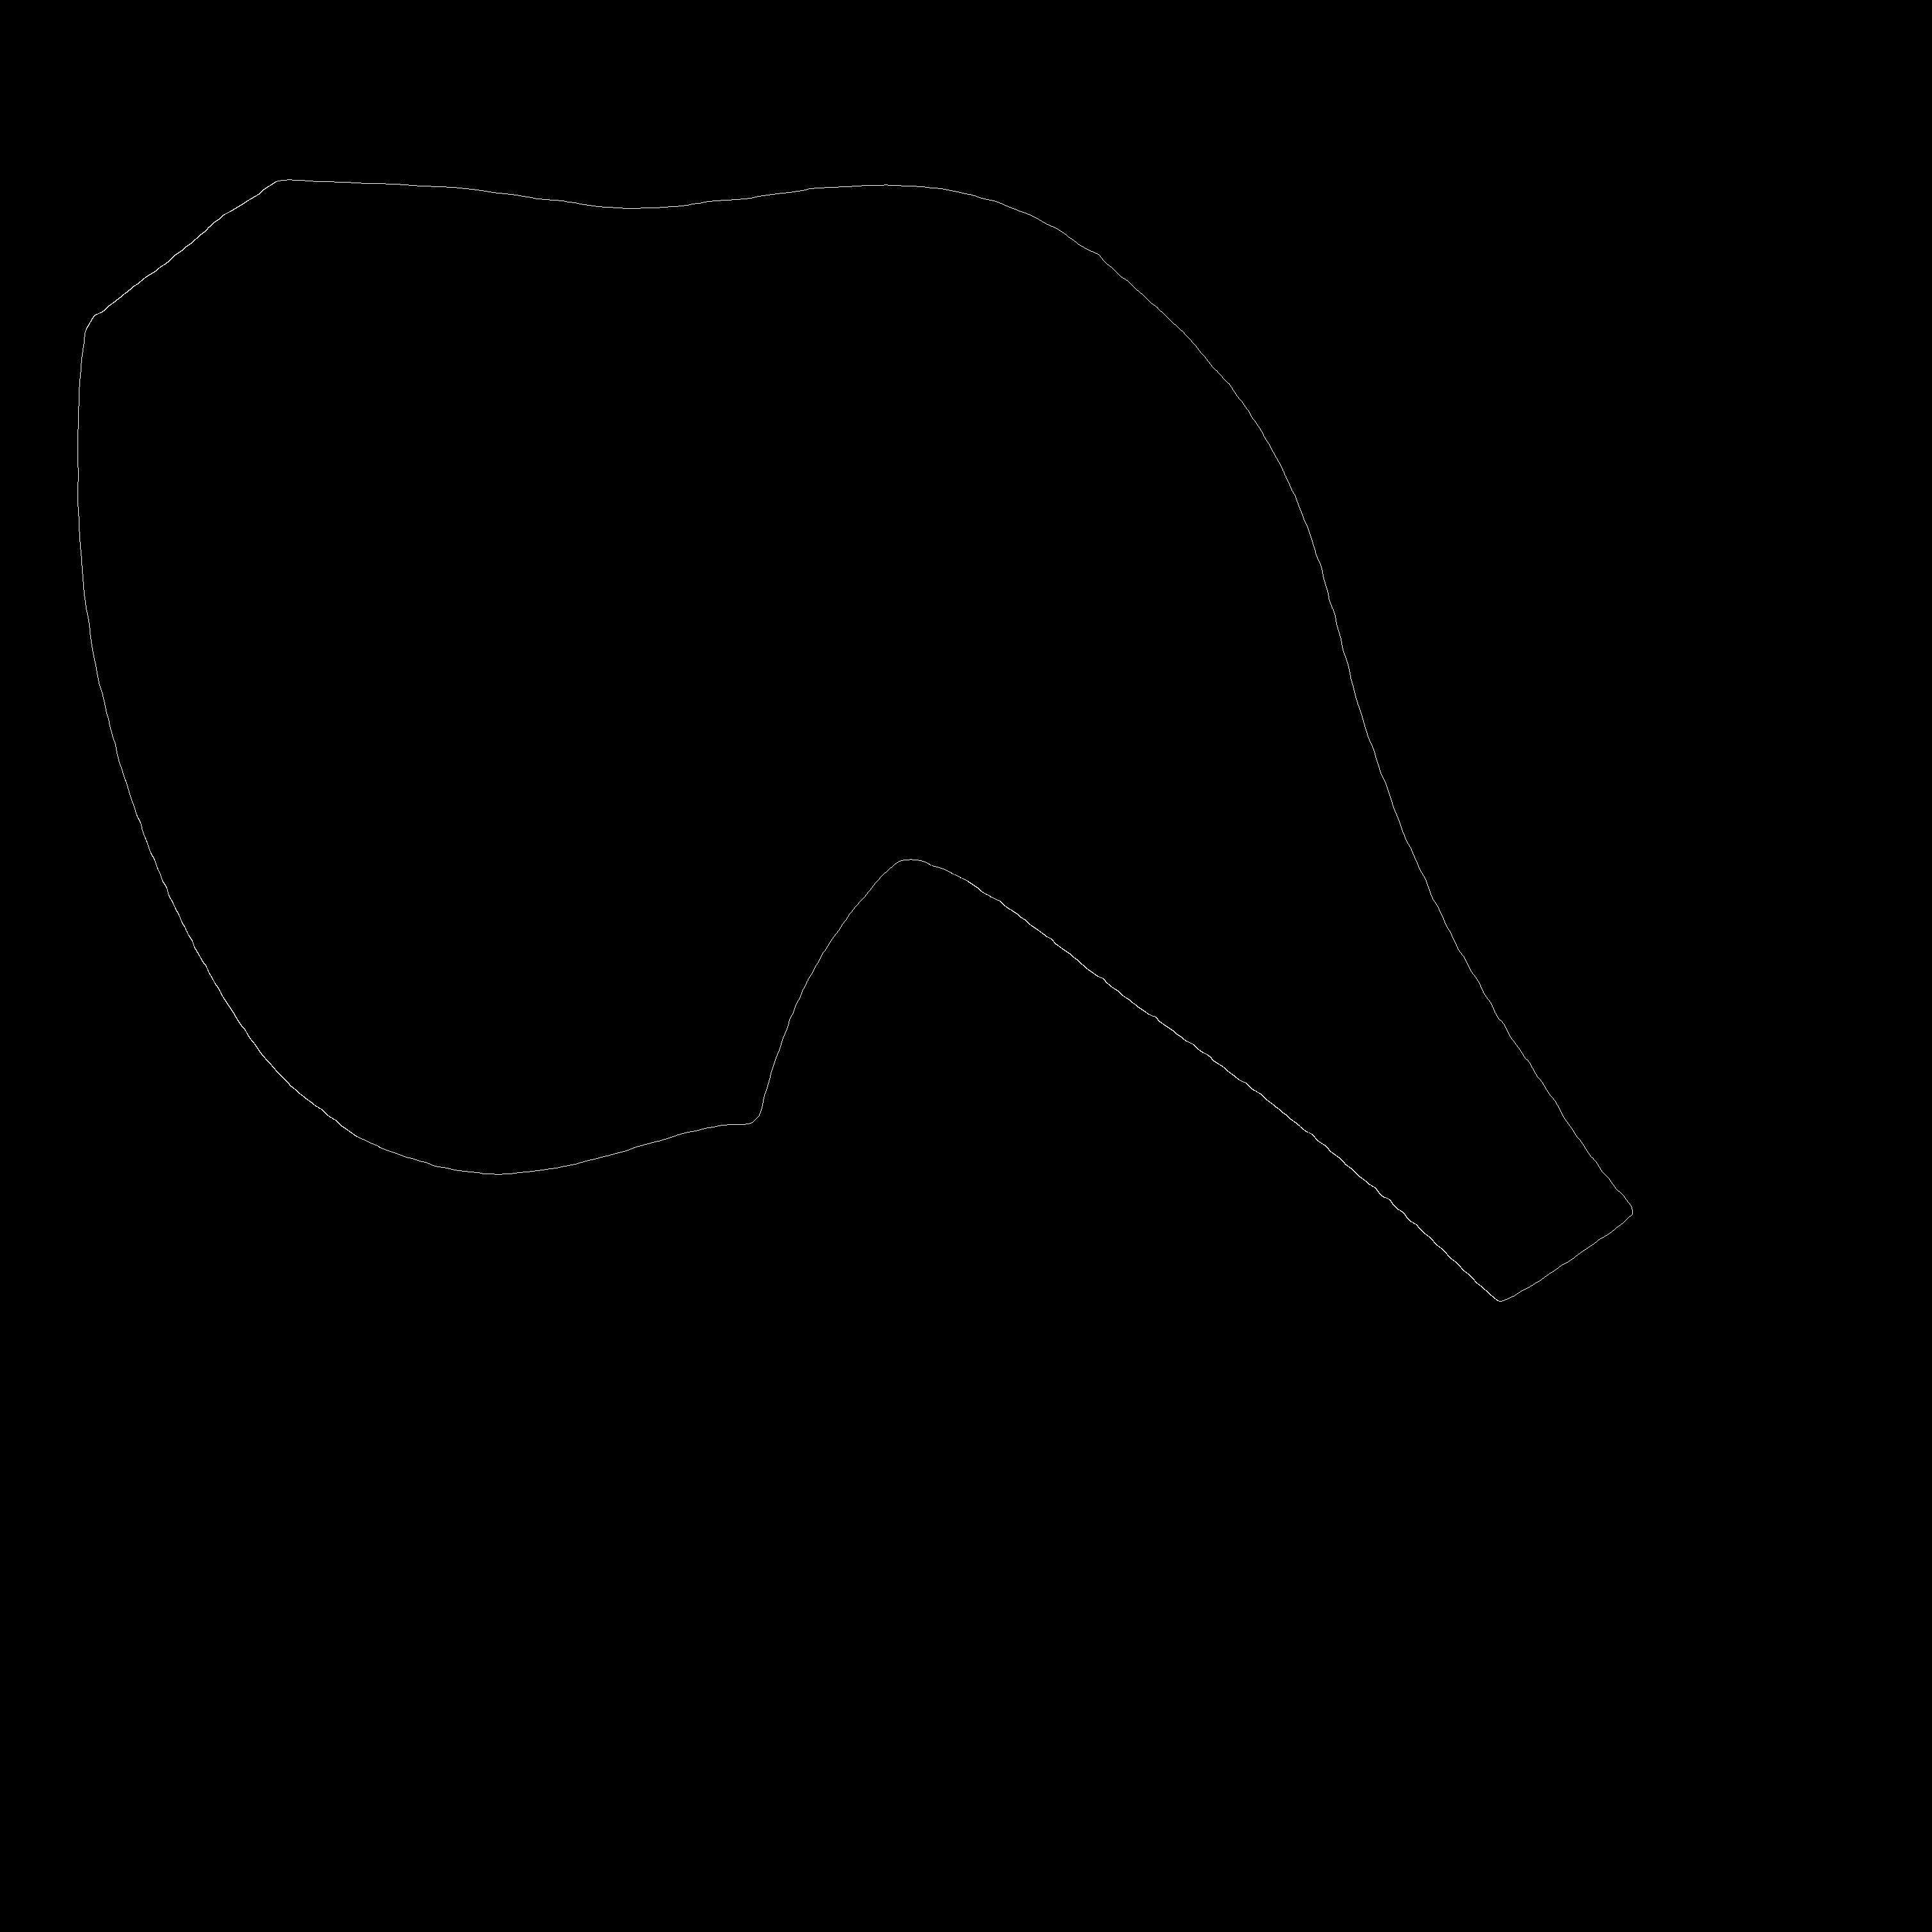

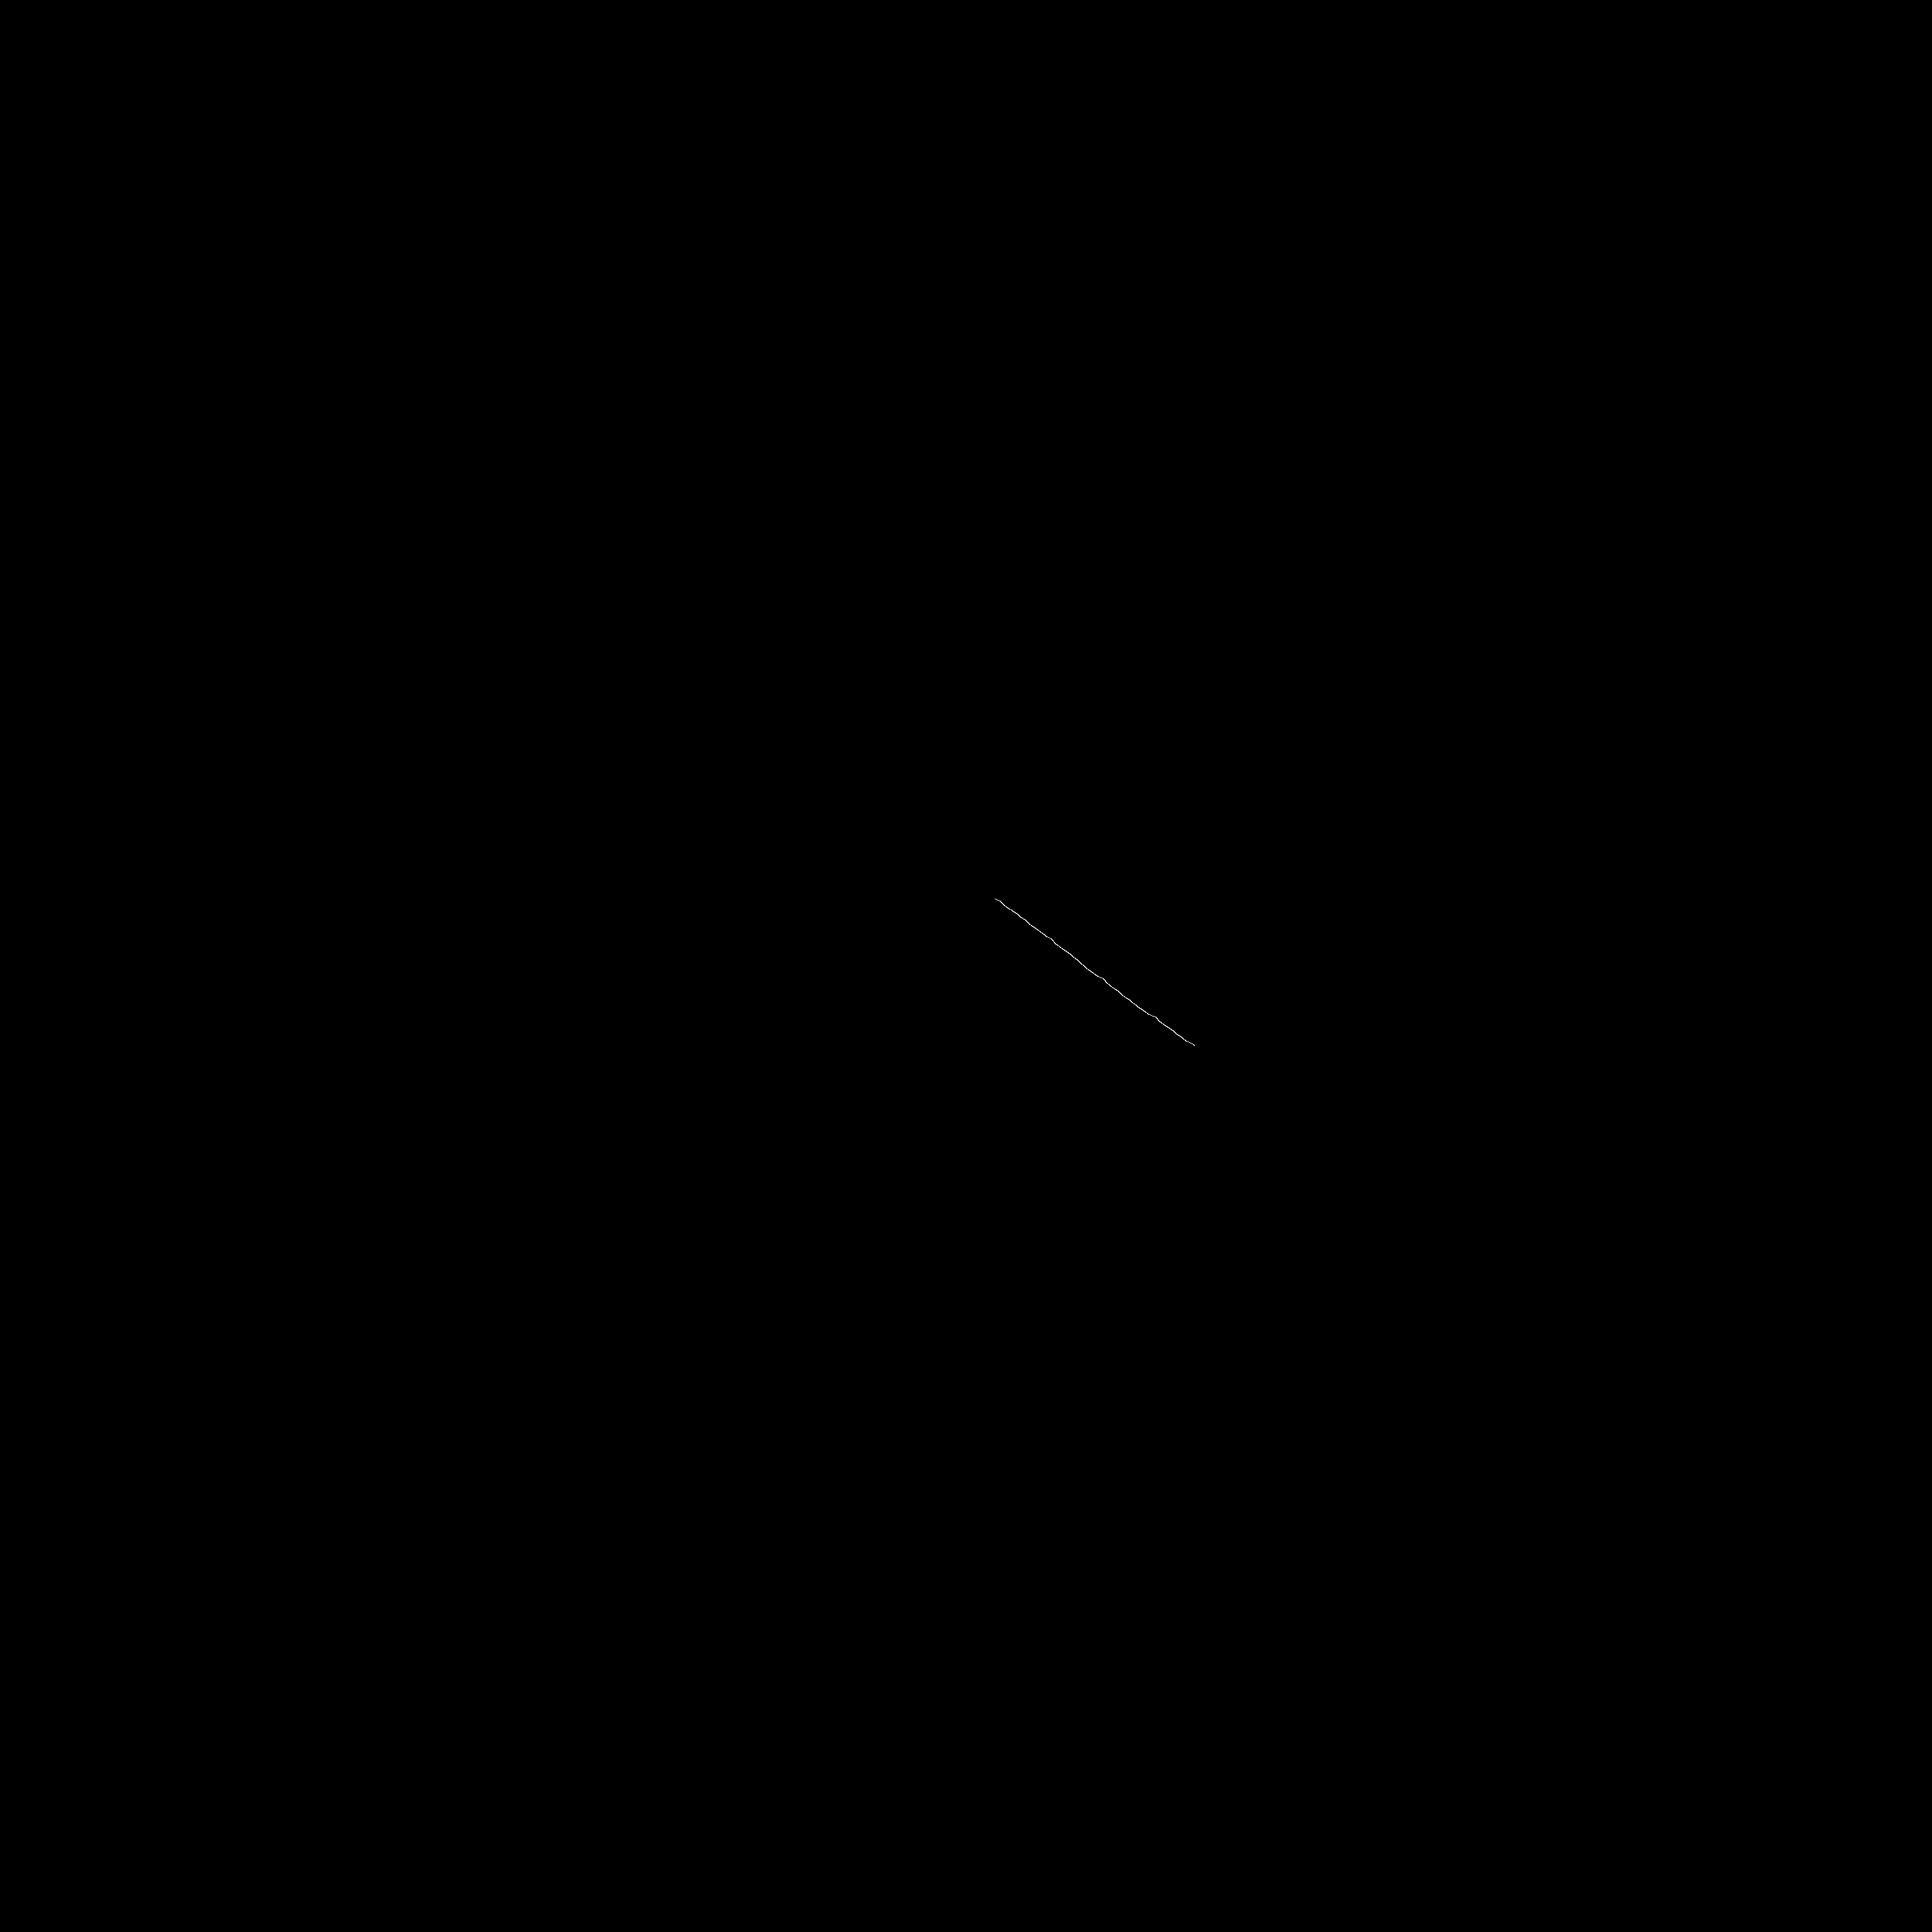

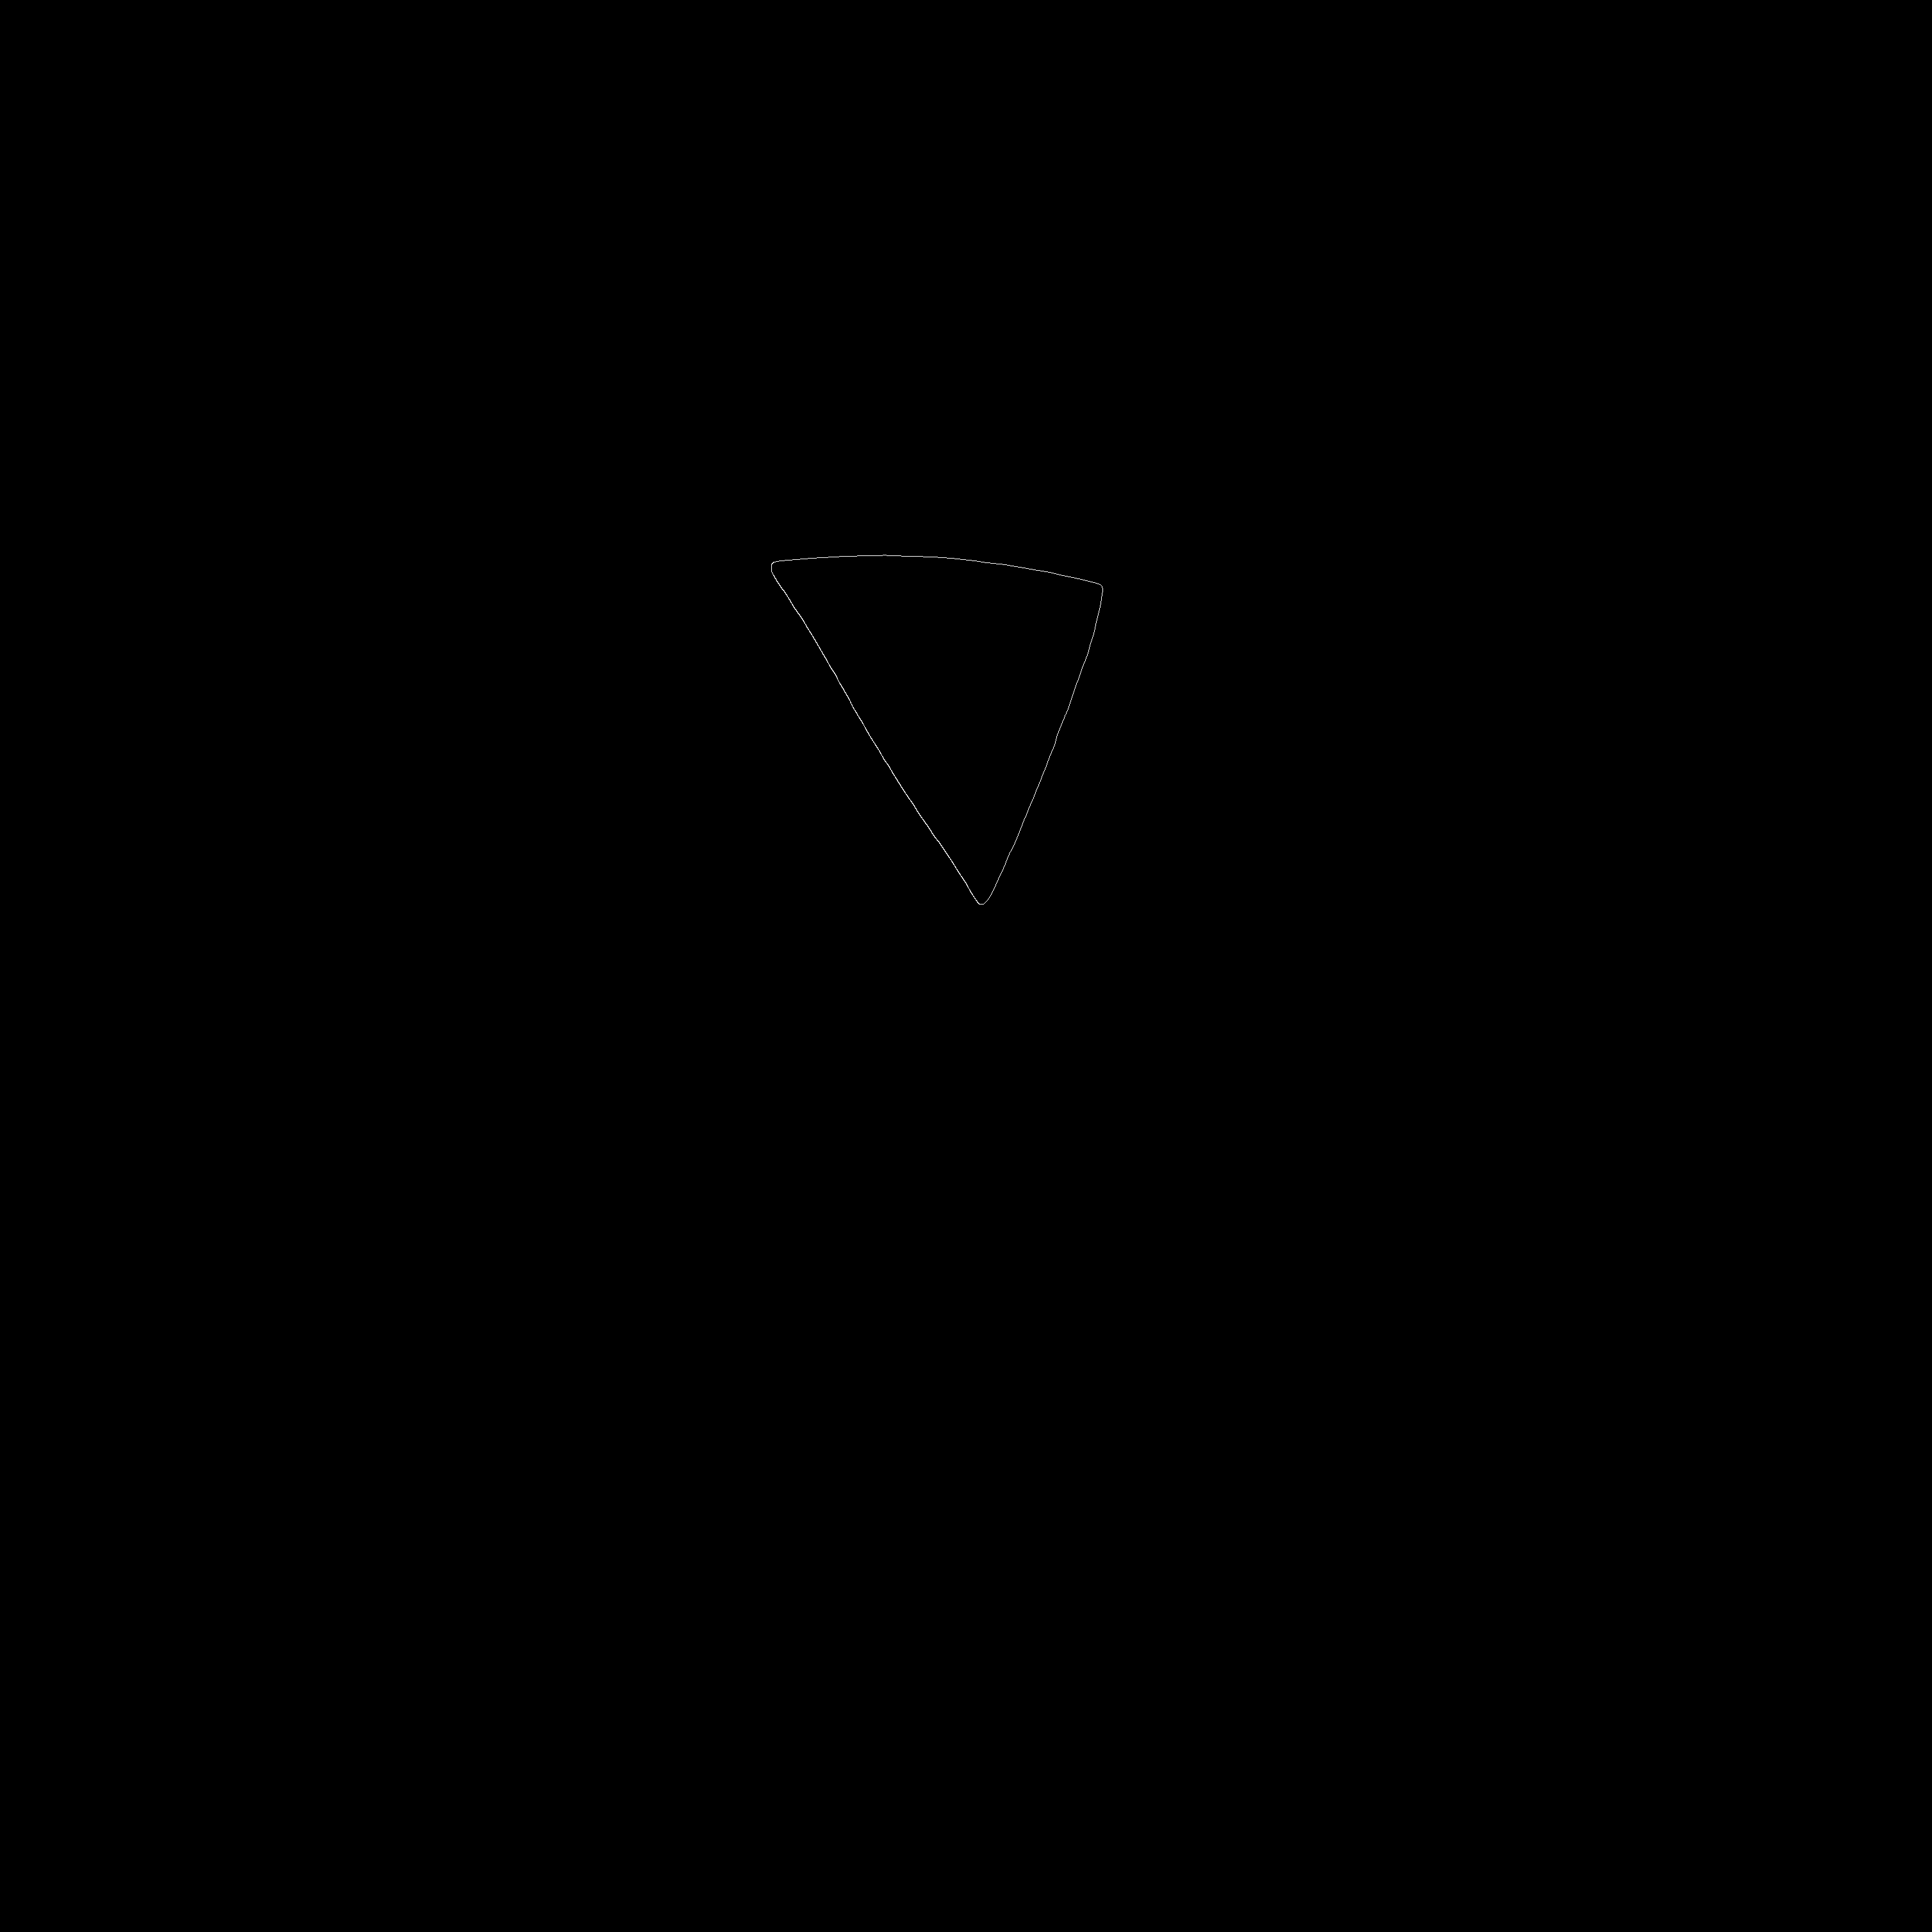

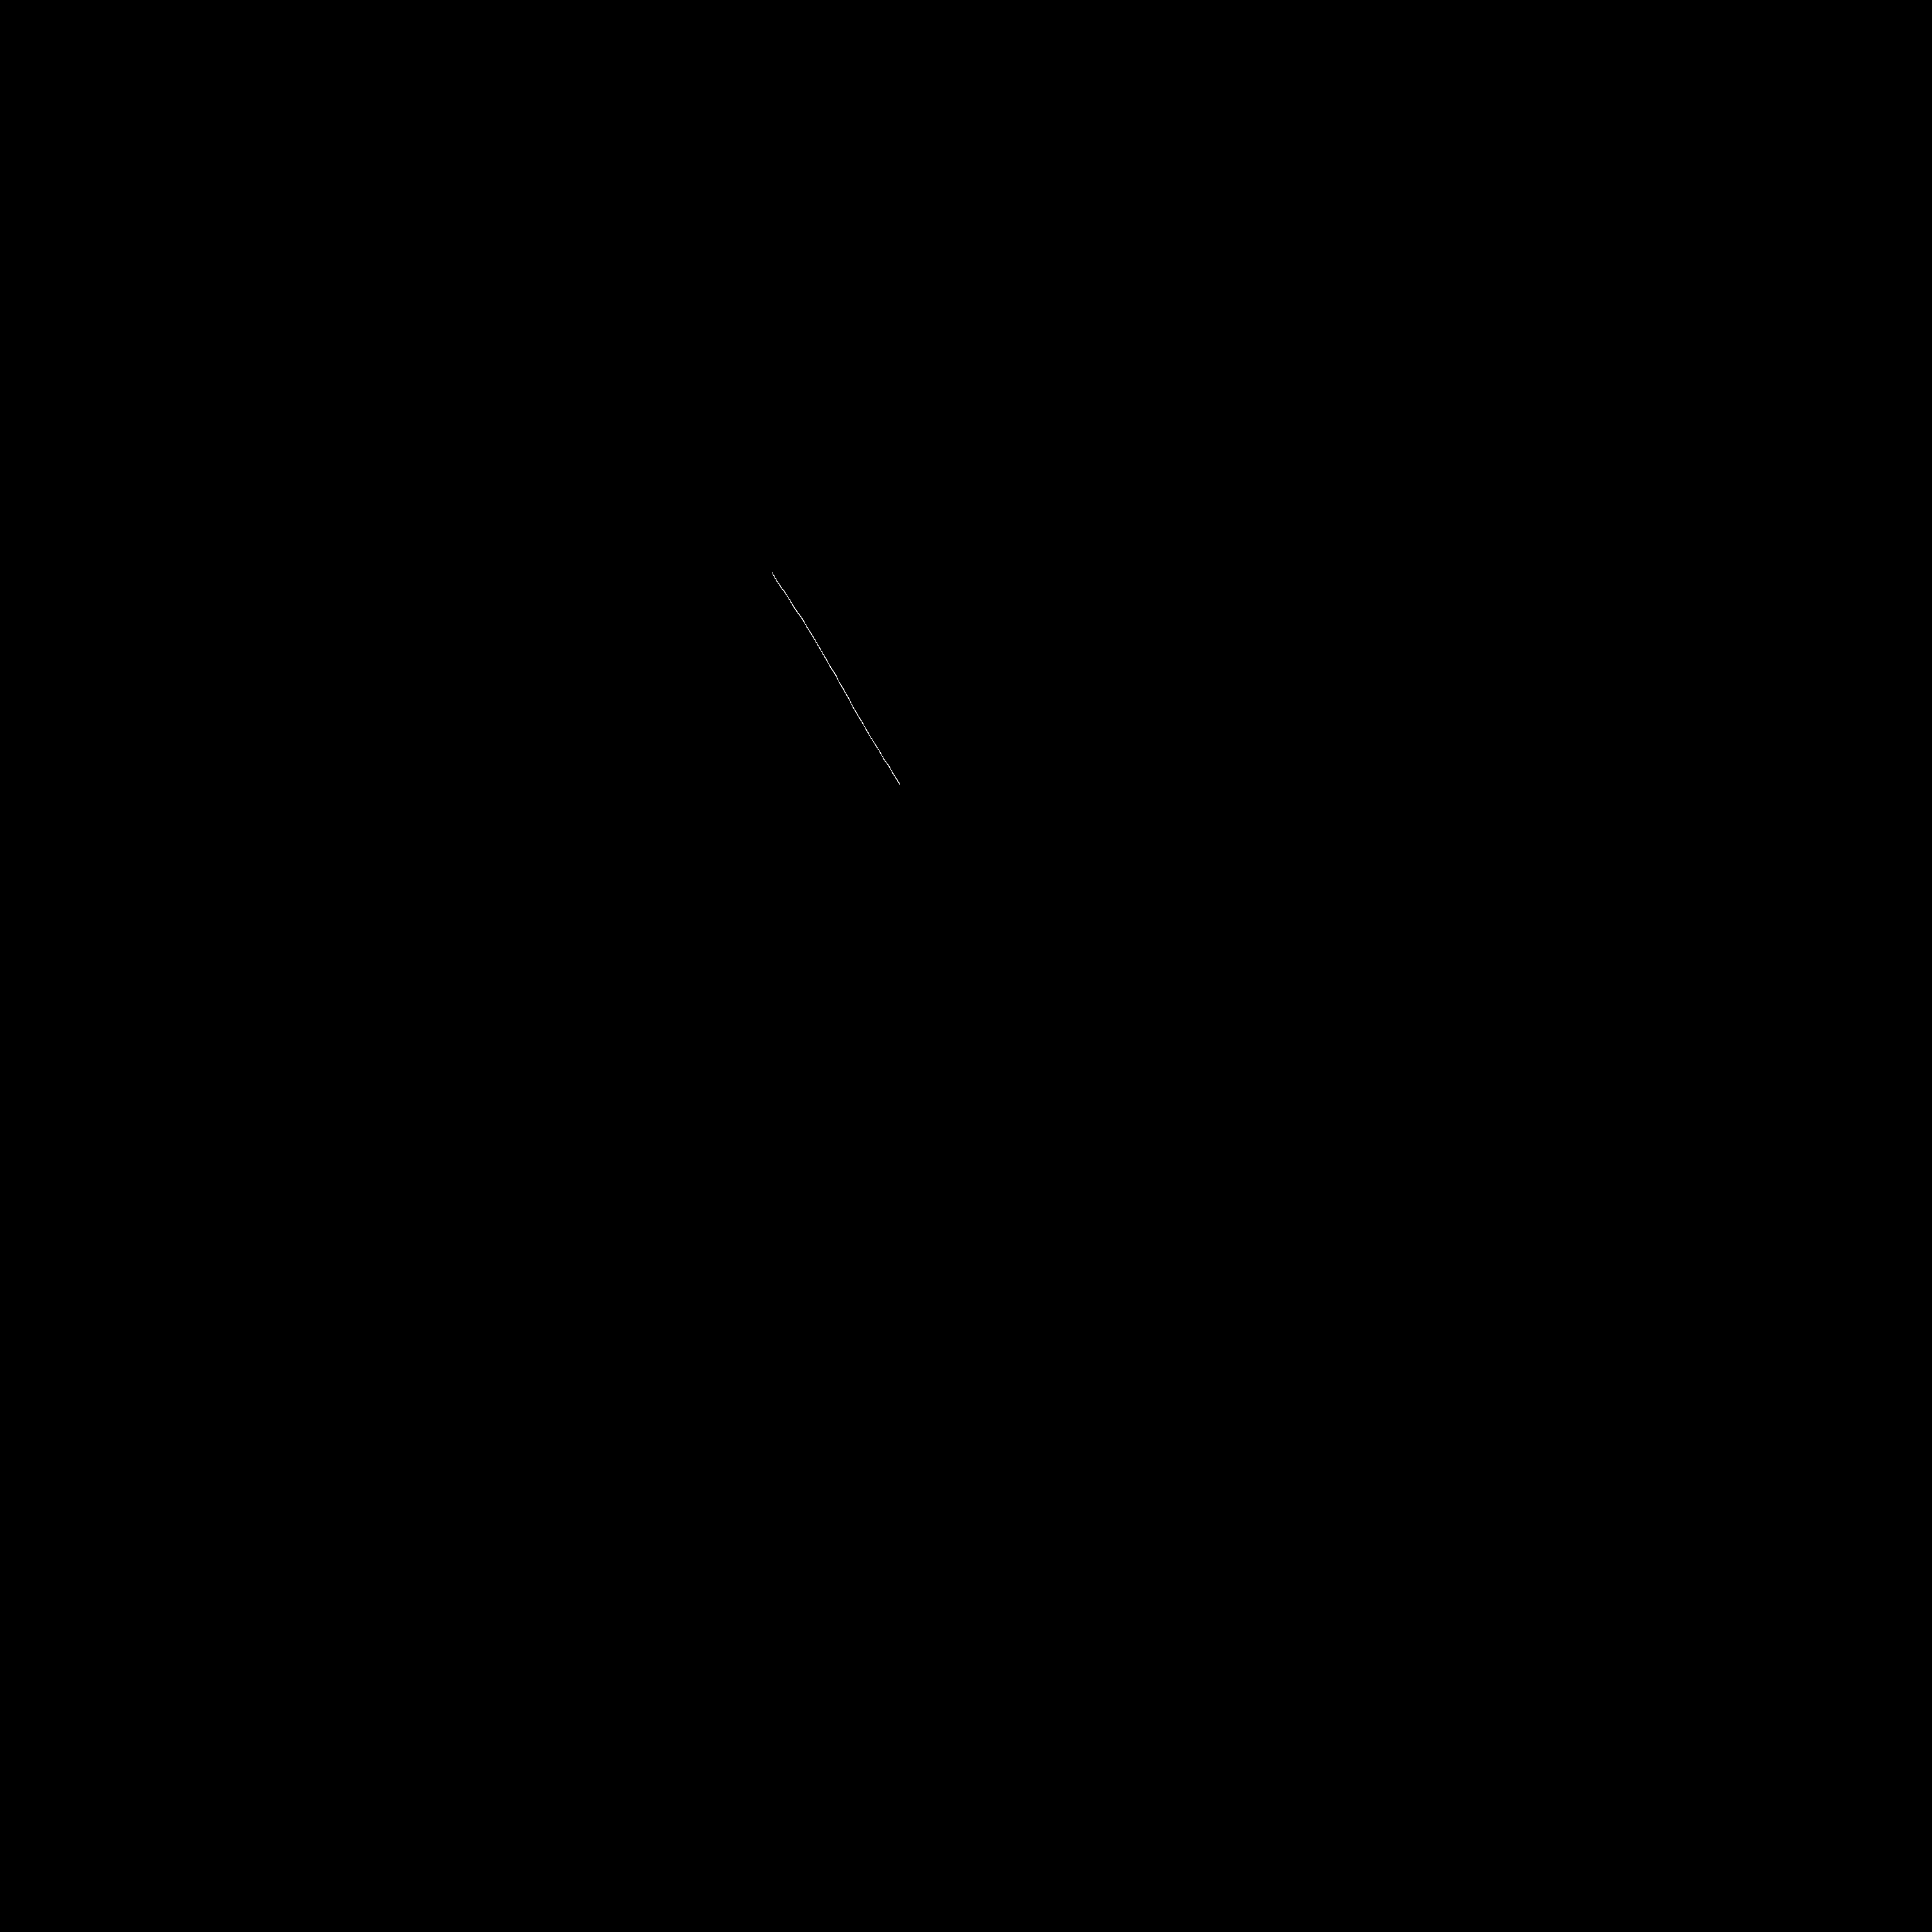

In [37]:
visualize(coords, contours[0], contours[3])

In [ ]:
#Questo plotta i due frammenti e due lati che combaciano
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[2][:, 0], contours[2][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[2][350:550, 0], contours[2][350:550, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[1][:, 0], contours[1][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[1][2100:2300, 0], contours[1][2100:2300, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)


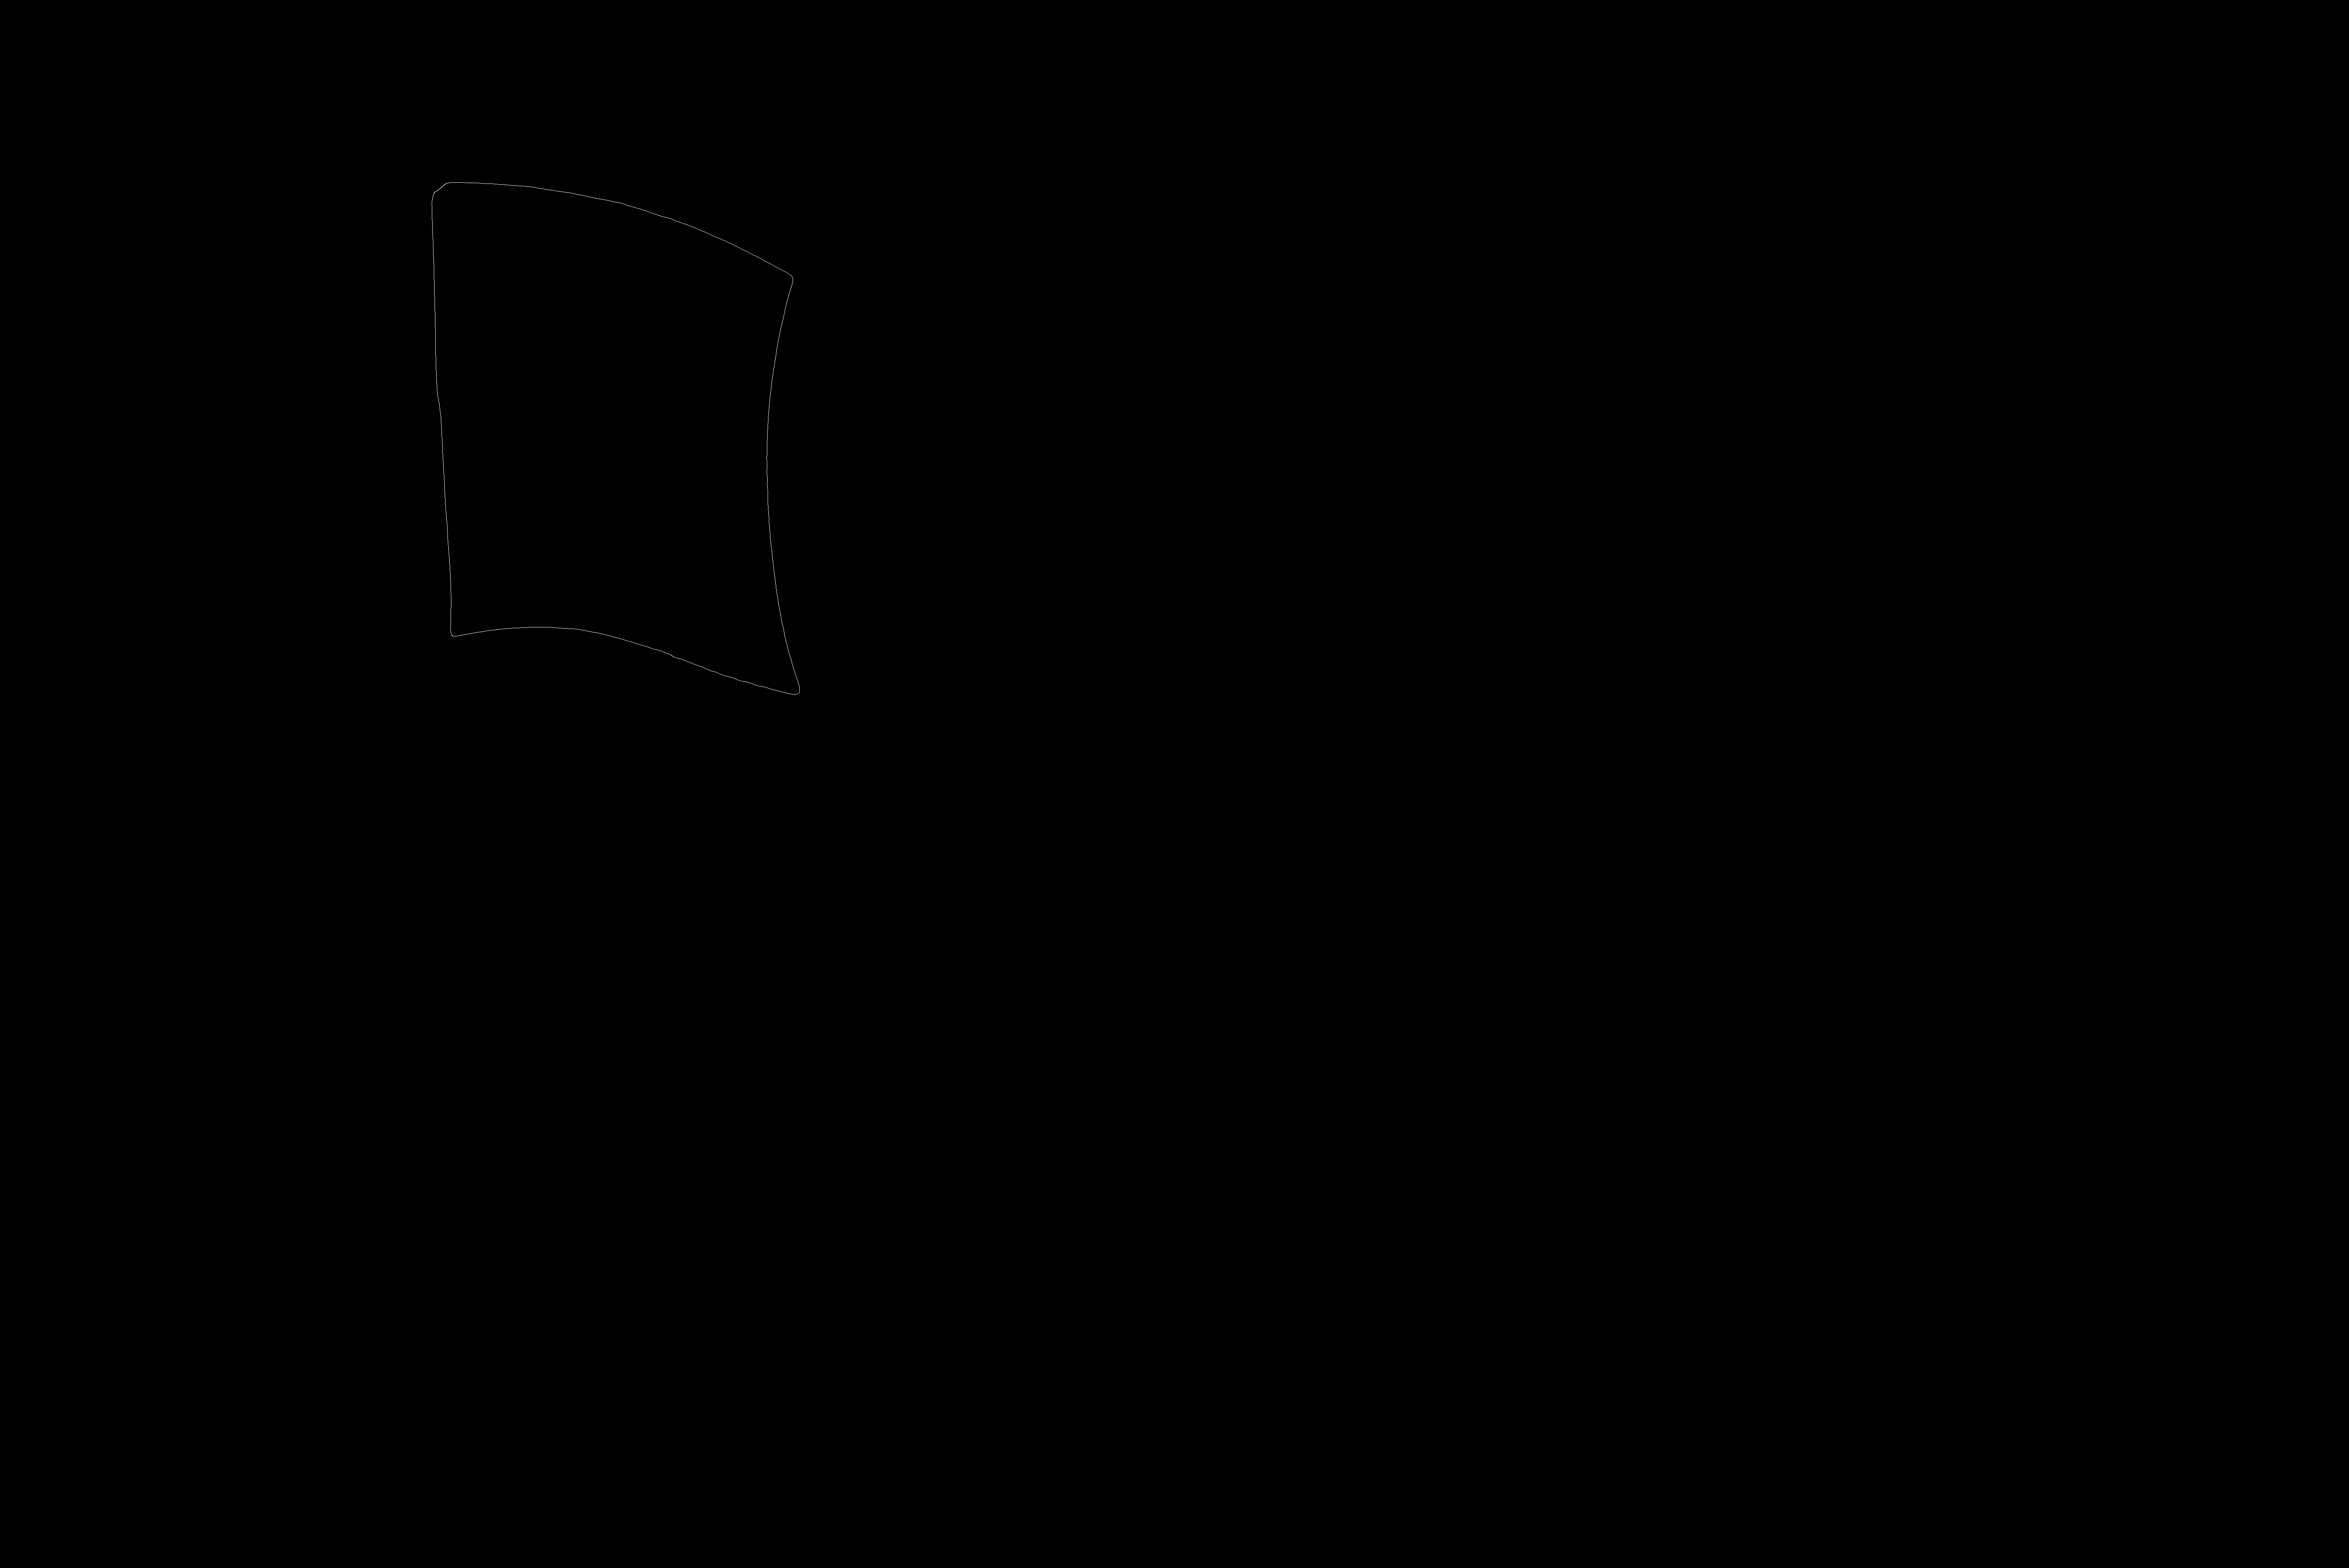

In [ ]:
seg_edge = np.zeros((4016, 6016))
x_coords, y_coords = contours[2][:, 0], contours[2][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)